In [2]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from pathlib import Path

from src.utils import read_jsonl, write_jsonl

In [2]:
from src.utils import load_config
from datasets import Dataset, load_dataset
from src.model import cls_load_epic

config = load_config()

epic = pd.DataFrame(load_dataset(config['DATASET_NAME'])['train'])
epic.head()

,user,label,timestamp,source,subreddit,id_original,text,parent_id_original,parent_text,Language_instance,Language_variety,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language_annotator,Student status,Employment status
0,5dcff5909595a10f6241c0f6,iro,2022-11-05 11:11:23,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,24,Male,White,United Kingdom,United Kingdom,United Kingdom,English,No,Full-Time
1,55057a56fdf99b5b566a70bb,not,2022-11-05 12:10:00,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,29,Female,White,United Kingdom,United Kingdom,United Kingdom,English,No,DATA_EXPIRED
2,5721b3054d5b26001301f651,iro,2022-11-26 13:07:54,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,33,Male,Asian,Australia,Australia,India,English,No,Full-Time
3,60e016cd61cd6e8d3d185ff3,not,2022-11-25 18:47:48,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,41,Female,White,Ireland,Ireland,Ireland,English,No,Part-Time
4,59fc8aba087f2e0001ead671,not,2022-11-25 18:44:10,reddit,AskReddit,fj5bt7i,but we should have just named the first genera...,fj59kca,Because the last generation was Gen. Z and the...,en,us,42,Female,White,Ireland,Ireland,Ireland,English,No,Full-Time


In [3]:
agreements = [] 
for id in epic['id_original'].unique():
    labels = epic[epic['id_original'] == id]['label']
    agreements.append((id, max((labels == 'iro').sum(), (labels == 'not').sum()) / len(labels)))
agreements = pd.DataFrame(agreements, columns=['id', 'agreement'])
agreements.describe()

,agreement
count,3000.000000
mean,0.793947
std,0.169727
min,0.500000
25%,0.600000
50%,0.800000
75%,1.000000
max,1.000000


In [4]:
def get_golds_preds(split):
    golds = [item['gold'] for item in split]
    preds = [item['pred'] for item in split]
    return golds, preds

In [5]:
for r in [.5, .6, .7, .8, .9, 1]:
    ids = agreements[agreements['agreement'] >= r]['id'].tolist()
    metrics = []
    data = list(filter(lambda x: x['id_original'] in ids, read_jsonl('results/open/epic_open_zs.jsonl')))
    golds = [item['gold'] == 1 for item in data]
    preds = [item['outputs'].split('[/INST]')[-1].strip().lower().startswith('yes') for item in data]
    print(r, len(ids), len(data), f"{round(matthews_corrcoef(golds, preds), 3)}")

0.5 3000 990 -0.033
0.6 2750 990 -0.033
0.7 2038 990 -0.033
0.8 1673 990 -0.033
0.9 990 990 -0.033
1 990 990 -0.033


In [110]:
for r in [.5, .6, .7, .8, .9, 1]:
    ids = agreements[agreements['agreement'] >= r]['id'].tolist()
    metrics = []
    data = list(filter(lambda x: x['id_original'] in ids, read_jsonl('results/close/epic_random_closed_double_zs.jsonl')[0]))
    golds, preds = get_golds_preds(data)
    print(r, len(ids), len(data), f"{round(matthews_corrcoef(golds, preds), 3)}")

0.5 3000 2767 0.176
0.6 2750 2750 0.178
0.7 2038 2038 0.192
0.8 1673 1673 0.207
0.9 990 990 0.228
1 990 990 0.228


In [111]:
tokenizer.apply_chat_template(turns, return_tensors='pt')

read_jsonl('results/close/epic_random_closed_double_zs.jsonl')[0]

[{'id_original': '1533769730712121344',
  'scores': [0.03355834633111954, 0.9664416313171387],
  'gold': 1,
  'pred': 1,
  'turns': [{'role': 'system', 'content': 'You are a helpful assistant.'},
   {'role': 'user',
    'content': "Below is a dialogue between user A and user B.\n\nUser A:Eh carra you got shit banter for a scouser fucking hell la you been hanging out with Neville too long oasis piss all over the Beatles how many times did they do knebworth\nUser B:@liamgallagher Piss all over the Beatles??? U should b flogged fr saying such tings, n ur dreams Liam, U are overrated, the Beatles ar not, end of.\n\nIs B's answer to A ironic?Answer by yes or no."},
   {'role': 'assistant', 'content': 'The answer is'}],
  'seed_phs': {'labels': 0,
   'system': 0,
   'user': 0,
   'assistant': 0,
   'intro': 0,
   'input': 0,
   'question': 0,
   'format': 0},
  'subs': ['system',
   'user',
   'intro',
   'question',
   'format',
   'input',
   'labels',
   'parent_text',
   'text',
   'assi

## tweeteval_open

In [72]:
data = read_jsonl('results/open/tweeteval_open_zs.jsonl')
golds = [item['gold'] == 1 for item in data]
preds = [item['outputs'].split('[/INST]')[-1].strip().lower().startswith('yes') for item in data]
print(len(golds), len(preds))
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

784 784
0.019075954959884508


{'False': {'precision': 0.6148867313915858,
  'recall': 0.40169133192389006,
  'f1-score': 0.48593350383631706,
  'support': 473.0},
 'True': {'precision': 0.40421052631578946,
  'recall': 0.617363344051447,
  'f1-score': 0.4885496183206106,
  'support': 311.0},
 'accuracy': 0.4872448979591837,
 'macro avg': {'precision': 0.5095486288536877,
  'recall': 0.5095273379876686,
  'f1-score': 0.48724156107846384,
  'support': 784.0},
 'weighted avg': {'precision': 0.5313149204495289,
  'recall': 0.4872448979591837,
  'f1-score': 0.4869712737401631,
  'support': 784.0}}

In [100]:
df = pd.read_csv('data/sem-eval/test.txt', sep='\t')
data = read_jsonl('results/open/tweeteval_open_zs.jsonl')
data = list(filter(lambda x: x['id_original'].startswith('test'), data))
for label in sorted(df['Label'].unique()):
    print("#####" + str(label) + "#####")
    metrics = []
    df['gold'] = [item['gold'] == 1 for item in data]
    df['pred'] = [item['outputs'].split('[/INST]')[-1].strip().lower().startswith('yes') for item in data]
    golds, preds = get_golds_preds(df[df['Label'] == label].to_dict(orient='records'))
    print(len(preds), len(golds), sum(preds))
    print(matthews_corrcoef(golds, preds))
    print(classification_report(golds, preds, output_dict=True)['accuracy'])

#####0#####
473 473 283
0.0
0.40169133192389006
#####1#####
164 164 91
0.0
0.5548780487804879
#####2#####
85 85 63
0.0
0.7411764705882353
#####3#####
62 62 38
0.0
0.6129032258064516


c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\skle

In [73]:
sum([item['outputs'].split('[/INST]')[-1].strip().lower().startswith('yes') or item['outputs'].split('[/INST]')[-1].strip().lower().startswith('no') for item in data])

758

In [71]:
[item['outputs'].split('[/INST]')[-1].strip().lower() for item in data]

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [112]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")


In [120]:
data = read_jsonl('results/open/tweeteval_open_zs.jsonl')
print(tokenizer.decode(tokenizer.apply_chat_template(data[1]['turns'])))

Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


<s> [INST] <<SYS>>
You are a helpful assistant
<</SYS>>

Classify the following tweet: : Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha

 as ironic or not.Answer only by yes or no. [/INST] Yes, the tweet is ironic. </s><s> [INST] Answer only by yes or no. [/INST]


## epic_open_zs

In [8]:
data = read_jsonl('results/open/epic_open_zs.jsonl')
golds = [item['gold'] == 1 for item in data]
preds = [item['outputs'].split('[/INST]')[-1].strip().lower().startswith('yes') for item in data]
print(len(golds), len(preds))
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

990 990
-0.03337954566807481


{'False': {'precision': 0.8571428571428571,
  'recall': 0.11630558722919042,
  'f1-score': 0.20481927710843373,
  'support': 877.0},
 'True': {'precision': 0.11021814006888633,
  'recall': 0.8495575221238938,
  'f1-score': 0.1951219512195122,
  'support': 113.0},
 'accuracy': 0.2,
 'macro avg': {'precision': 0.4836804986058717,
  'recall': 0.4829315546765421,
  'f1-score': 0.19997061416397297,
  'support': 990.0},
 'weighted avg': {'precision': 0.7718878136788584,
  'recall': 0.2,
  'f1-score': 0.2037124106180821,
  'support': 990.0}}

In [69]:
[item['outputs'].split('[/INST]')[-1].strip().lower() for item in data]

990

In [4]:
data = read_jsonl('results/close/epic_random_closed_double_zs.jsonl')[0]
# data = list(filter(lambda x: x['id_original'].startswith('test'), data))
golds, preds = get_golds_preds(data)
print(len(golds), len(preds))
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

2767 2767
0.17591865609220347


{'0': {'precision': 0.8553682342502218,
  'recall': 0.45514636449480644,
  'f1-score': 0.5941448382126349,
  'support': 2118.0},
 '1': {'precision': 0.29634146341463413,
  'recall': 0.74884437596302,
  'f1-score': 0.42463958060288337,
  'support': 649.0},
 'accuracy': 0.5240332490061438,
 'macro avg': {'precision': 0.575854848832428,
  'recall': 0.6019953702289133,
  'f1-score': 0.5093922094077591,
  'support': 2767.0},
 'weighted avg': {'precision': 0.7242484748457055,
  'recall': 0.5240332490061438,
  'f1-score': 0.5543873708513307,
  'support': 2767.0}}

In [84]:
data[0]['pred'], data[0]['gold']

(1, 0)

In [ ]:
list().insert(225, {'id_original'})

In [8]:
last = -1
for item in data:
    current = int(item['id_original'].split('_')[-1])
    if current != last + 1:
        print(last, current)
    last = current

223 225
445 447


In [5]:
df = pd.read_csv('data/sem-eval/test.txt', sep='\t')
df = df.drop([224, 446])
data = read_jsonl('results/close/llama7b_last_tweeteval_predictions.jsonl')
data = list(filter(lambda x: x['id_original'].startswith('test'), data))
for label in sorted(df['Label'].unique()):
    print("#####" + str(label) + "#####")
    metrics = []
    df['pred'] = [item['pred'] for item in data]
    df['gold'] = [item['gold'] for item in data]
    golds, preds = get_golds_preds(df[df['Label'] == label].to_dict(orient='records'))
    print(len(preds), len(golds), sum(preds))
    print(matthews_corrcoef(golds, preds))
    print(classification_report(golds, preds, output_dict=True)['accuracy'])


#####0#####
471 471 90
0.0
0.8089171974522293
#####1#####
164 164 137
0.0
0.8353658536585366
#####2#####
85 85 41
0.0
0.4823529411764706
#####3#####
62 62 23
0.0
0.3709677419354839


c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\skle

In [10]:
df = pd.read_csv('data/sem-eval/test.txt', sep='\t')
data = read_jsonl('results/close/tweeteval_random_closed_single_zs.jsonl')[0]
data = list(filter(lambda x: x['id_original'].startswith('test'), data))
for label in sorted(df['Label'].unique()):
    print("#####" + str(label) + "#####")
    metrics = []
    df['pred'] = [item['pred'] for item in data]
    df['gold'] = [item['gold'] for item in data]
    golds, preds = get_golds_preds(df[df['Label'] == label].to_dict(orient='records'))
    print(len(preds), len(golds), sum(preds))
    print(matthews_corrcoef(golds, preds))
    print(classification_report(golds, preds, output_dict=True)['accuracy'])


#####0#####
473 473 326
0.0
0.3107822410147992
#####1#####
164 164 126
0.0
0.7682926829268293
#####2#####
85 85 73
0.0
0.8588235294117647
#####3#####
62 62 44
0.0
0.7096774193548387


c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\skle

Text(0.5, 0, 'Predicted label')

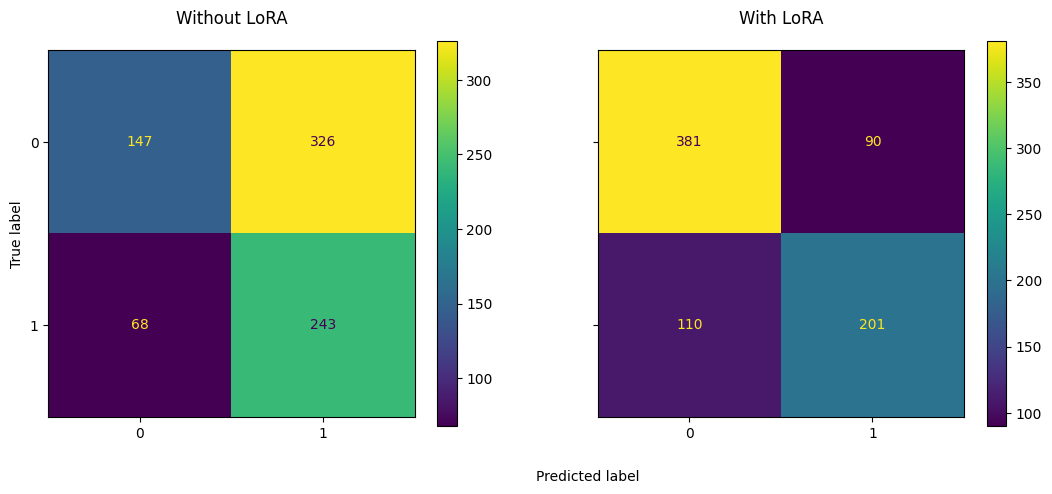

In [12]:
from matplotlib import pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(13, 5), sharey='row')

data = read_jsonl('results/close/tweeteval_random_closed_single_zs.jsonl')[0]
data = list(filter(lambda x: x['id_original'].startswith('test'), data))

golds, preds = get_golds_preds(data)

disp0 = ConfusionMatrixDisplay(confusion_matrix(golds, preds))
disp0.plot(ax=axes[0])
disp0.ax_.set_title('Without LoRA', y=1.05)
disp0.ax_.set_xlabel('')


data = read_jsonl('results/close/llama7b_last_tweeteval_predictions.jsonl')

golds, preds = get_golds_preds(data)

disp1 = ConfusionMatrixDisplay(confusion_matrix(golds, preds))
disp1.plot(ax=axes[1])
disp1.ax_.set_title('With LoRA', y=1.05)
disp1.ax_.set_xlabel('')
disp1.ax_.set_ylabel('')
f.text(0.5, 0, 'Predicted label', ha='left')

In [6]:
data = read_jsonl('results/close/tweeteval_random_closed_single_zs.jsonl')[0]
# data = list(filter(lambda x: x['id_original'].startswith('test'), data))
golds, preds = get_golds_preds(data)
print(len(golds), len(preds))
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

4601 4601
0.04085591380505758


{'0': {'precision': 0.5519379844961241,
  'recall': 0.2980326496442026,
  'f1-score': 0.38706170154933406,
  'support': 2389.0},
 '1': {'precision': 0.4935064935064935,
  'recall': 0.7386980108499096,
  'f1-score': 0.5917074053956183,
  'support': 2212.0},
 'accuracy': 0.5098891545316235,
 'macro avg': {'precision': 0.5227222390013088,
  'recall': 0.5183653302470561,
  'f1-score': 0.48938455347247617,
  'support': 4601.0},
 'weighted avg': {'precision': 0.5238461657460561,
  'recall': 0.5098891545316235,
  'f1-score': 0.4854482038114467,
  'support': 4601.0}}

In [5]:
data = read_jsonl('results/close/llama7b_last_epic_predictions.jsonl')
golds, preds = get_golds_preds(data)
print(len(golds), len(preds))
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

255 255
0.4237017130659008


{'0': {'precision': 0.8235294117647058,
  'recall': 0.9032258064516129,
  'f1-score': 0.8615384615384616,
  'support': 186.0},
 '1': {'precision': 0.6470588235294118,
  'recall': 0.4782608695652174,
  'f1-score': 0.55,
  'support': 69.0},
 'accuracy': 0.788235294117647,
 'macro avg': {'precision': 0.7352941176470589,
  'recall': 0.6907433380084151,
  'f1-score': 0.7057692307692308,
  'support': 255.0},
 'weighted avg': {'precision': 0.7757785467128028,
  'recall': 0.788235294117647,
  'f1-score': 0.7772398190045249,
  'support': 255.0}}

In [5]:
data = read_jsonl('results/close/llama7b_last_tweeteval_predictions.jsonl')
data = list(filter(lambda x: x['id_original'].startswith('test'), data))
golds, preds = get_golds_preds(data)
print(len(golds), len(preds))
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

782 782
0.46091858037244277


{'0': {'precision': 0.7759674134419552,
  'recall': 0.8089171974522293,
  'f1-score': 0.7920997920997921,
  'support': 471.0},
 '1': {'precision': 0.6907216494845361,
  'recall': 0.6463022508038585,
  'f1-score': 0.6677740863787376,
  'support': 311.0},
 'accuracy': 0.7442455242966752,
 'macro avg': {'precision': 0.7333445314632456,
  'recall': 0.7276097241280439,
  'f1-score': 0.7299369392392648,
  'support': 782.0},
 'weighted avg': {'precision': 0.7420653257299893,
  'recall': 0.7442455242966752,
  'f1-score': 0.7426556815125186,
  'support': 782.0}}

In [5]:
data = read_jsonl('results/close/tweeteval_random_closed_single_zs.jsonl')[0]
data = list(filter(lambda x: x['id_original'].startswith('test'), data))
golds, preds = get_golds_preds(data)
print(len(golds), len(preds))
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

784 784
0.10102975743695315


{'0': {'precision': 0.6837209302325581,
  'recall': 0.3107822410147992,
  'f1-score': 0.4273255813953488,
  'support': 473.0},
 '1': {'precision': 0.4270650263620387,
  'recall': 0.7813504823151125,
  'f1-score': 0.5522727272727272,
  'support': 311.0},
 'accuracy': 0.49744897959183676,
 'macro avg': {'precision': 0.5553929782972984,
  'recall': 0.5460663616649558,
  'f1-score': 0.48979915433403803,
  'support': 784.0},
 'weighted avg': {'precision': 0.5819097234675944,
  'recall': 0.49744897959183676,
  'f1-score': 0.47689007421150276,
  'support': 784.0}}

In [7]:
data = torch.load('results/llama7b_tweeteval_lora/predictions_0.pt')
write_jsonl('results/llama7b_tweeteval_lora/llama7b_tweeteval_lora_predictions.jsonl', data)

In [9]:
[tokenizer.decode(item['pred'][len(item['input_ids']):-1]) for item in data]

['### Output:\n### Explan',
 'Ironic\n### Output:\n',
 '### Output:\nIronic\n',
 'Ironic\n### Output:\n',
 'Ironic\n### Explanation',
 '### Output:\n### Example:',
 'Ironic\n### Explanation',
 'Ironic\n### Explanation',
 '### Output:\nironic\n##',
 'Ironic\n',
 '### Output:\nIronic\n',
 'Ironic\n### Explanation',
 'Irkonic\n### Explan',
 '### Output:\nTrue\n###',
 '### Output:\nIronic\n',
 '### Output:\nIronic\n',
 'This tweet is ironic\n###',
 'Ironic\n### Explanation',
 '@user Re: Jamie Grace has T',
 'Ironic\n### Output:\n',
 '### Output:\nIronic\n',
 'Ironic\n### Output:\n',
 'Ironic\n### Explanation',
 'Ironic\n### Explanation',
 "### Output:\nI'm doing",
 '@user is ironic\n### Output',
 'Not ironic\n### Output:\n',
 'Ironic\n### Output:\n',
 'Ironic\n### Explanation',
 '### Output:\nIronic',
 'Ironic\n### Output:\n',
 '### Output:\nIronic\n',
 'Not ironic\n### Output:\n',
 'Irkonic\n### Explan',
 'Ironic\n\n### Explan',
 'Ironic\n### Explanation',
 '### Output:\n### Example:',
 '

In [41]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
data = read_jsonl('results/llama7b_tweeteval_lora/llama7b_tweeteval_lora_predictions.jsonl')
golds = [tokenizer.decode(item['gold'][:-1]).lower().startswith('ir') for item in data]
preds = [tokenizer.decode(item['pred'][len(item['input_ids']):-1]).lower().startswith('ir') for item in data]

print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

0.06148793436707797


{'False': {'precision': 0.6351351351351351,
  'recall': 0.49682875264270615,
  'f1-score': 0.5575326215895611,
  'support': 473.0},
 'True': {'precision': 0.4251207729468599,
  'recall': 0.5659163987138264,
  'f1-score': 0.48551724137931035,
  'support': 311.0},
 'accuracy': 0.5242346938775511,
 'macro avg': {'precision': 0.5301279540409976,
  'recall': 0.5313725756782662,
  'f1-score': 0.5215249314844357,
  'support': 784.0},
 'weighted avg': {'precision': 0.5518258664609595,
  'recall': 0.5242346938775511,
  'f1-score': 0.5289652960214642,
  'support': 784.0}}

In [49]:
len(data), sum(
    [
        (
            tokenizer.decode(item['pred'][len(item['input_ids']):-1]).lower().startswith('ir') or
            tokenizer.decode(item['pred'][len(item['input_ids']):-1]).lower().startswith('no')
            
        ) for item in data
    ]
)

(784, 466)

<Axes: xlabel='epoch', ylabel='loss'>

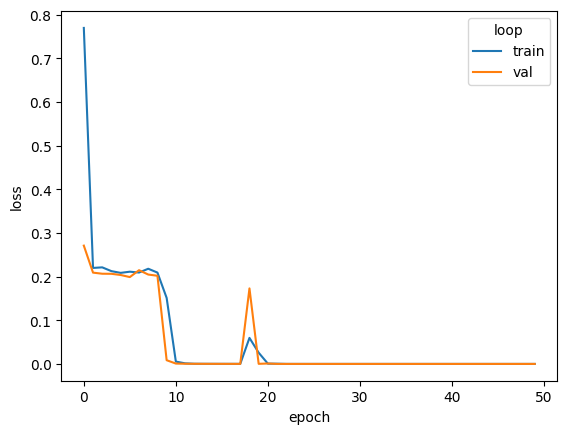

In [50]:
df = pd.read_csv('results/llama7b_tweeteval_lora/metrics.csv')
rows = []
for epoch in df['epoch'].unique():
    x = df[df['epoch'] == epoch].tail(2).reset_index()
    rows.append((epoch, x['train_loss'].values[1], 'train'))
    rows.append((epoch, x['val_loss'].values[0], 'val'))
df.head()
sns.lineplot(pd.DataFrame(rows, columns=['epoch', 'loss', 'loop']), x='epoch', y='loss', hue="loop")

In [53]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-7b1")
data = read_jsonl('results/bloom7b_tweeteval_lora/bloom7b_tweeteval_lora_predictions.jsonl')
golds = [tokenizer.decode(item['gold'][:-1]) for item in data]
preds = [tokenizer.decode(item['pred'][len(item['input_ids']):-1])for item in data]

print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

0.0


c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\si

{'<unk><unk><unk><unk><unk><unk><unk><unk><unk>': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 0.0},
 'ironic': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 311.0},
 'no ironic': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 473.0},
 'accuracy': 0.0,
 'macro avg': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 784.0},
 'weighted avg': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 784.0}}

In [58]:
tokenizer.decode(data[0]['pred'])

'<s>Tweet text : @user Can U Help?||More conservatives needed on #TSU + get paid 4 posting stuff like this!||YOU $ can go to Label : <unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>'

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-7b1")
data = read_jsonl('results/last/tweeteval_bloom7b_predictions.jsonl')
golds = [tokenizer.decode(item['gold'][:-1]) for item in data]
preds = [tokenizer.decode(item['pred'][len(item['input_ids']):-1]) for item in data]
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)



0.2127953908021396


c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pierr\.conda\envs\irony\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 'ironic': {'precision': 0.6818181818181818,
  'recall': 0.32608695652173914,
  'f1-score': 0.4411764705882353,
  'support': 46.0},
 'no ironic': {'precision': 0.5866666666666667,
  'recall': 0.8461538461538461,
  'f1-score': 0.6929133858267718,
  'support': 52.0},
 'accuracy': 0.6020408163265306,
 'macro avg': {'precision': 0.42282828282828283,
  'recall': 0.3907469342251951,
  'f1-score': 0.3780299521383357,
  'support': 98.0},
 'weighted avg': {'precision': 0.6313296227581942,
  'recall': 0.6020408163265306,
  'f1-score': 0.5747511603066424,
  'support': 98.0}}

In [3]:
item = list(filter(lambda x: tokenizer.decode(x['pred'][len(x['input_ids']):-1]) == '', data))[0]
tokenizer.decode(item['pred'])

In [2]:
data = read_jsonl('results/tweeteval_llama_peft.jsonl')

In [3]:
MODEL_NAME = "meta-llama/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [10]:
for item in data:
    print(tokenizer.decode(item['pred'][len(item['input_ids']):-1]),  tokenizer.decode(item['gold'][:-1]).startswith('no'), "#", tokenizer.decode(item['gold'][:-1]), tokenizer.decode(item['pred'][len(item['input_ids']):-1]).startswith('no'))

no ironic True # no ironic True
no ironic True # no ironic True
iris False # ironic False
no ironic False # ironic True
ironic True # no ironic False
ironic True # no ironic False
no ironic True # no ironic True
no ironic True # no ironic True
ironic False # ironic False
no iris no iris False # ironic True
no ironic False # ironic True
ironic False # ironic False
ironic True # no ironic False
no ironic True # no ironic True
no ironic False # ironic True
ironic True # no ironic False
ironic True # no ironic False
iris False # ironic False
iris True # no ironic False
ironic False # ironic False
no ironic False # ironic True
no ironic False # ironic True
ironic True # no ironic False
no iris False # ironic True
no iris True # no ironic True
no ironic False # ironic True
no ironic True # no ironic True
iris no iris False # ironic False
no ironic True # no ironic True
no ironic True # no ironic True
no ironic False # ironic True
no ironic False # ironic True
no iris True # no ironic True
no

In [9]:
golds = [not tokenizer.decode(item['gold'][:-1]).startswith('no') for item in data]
preds = [not tokenizer.decode(item['pred'][len(item['input_ids']):-1]).startswith('no') for item in data]
print(matthews_corrcoef(golds, preds))
classification_report(golds, preds, output_dict=True)

0.03845677843921982


{'False': {'precision': 0.6379310344827587,
  'recall': 0.6065573770491803,
  'f1-score': 0.6218487394957983,
  'support': 61.0},
 'True': {'precision': 0.4,
  'recall': 0.43243243243243246,
  'f1-score': 0.4155844155844156,
  'support': 37.0},
 'accuracy': 0.5408163265306123,
 'macro avg': {'precision': 0.5189655172413794,
  'recall': 0.5194949047408064,
  'f1-score': 0.518716577540107,
  'support': 98.0},
 'weighted avg': {'precision': 0.5480999296270233,
  'recall': 0.5408163265306123,
  'f1-score': 0.5439734335292559,
  'support': 98.0}}

In [4]:
def get_golds_preds(split):
    golds = [item['gold'] for item in split]
    preds = [item['pred'] for item in split]
    return golds, preds

def evaluate_result(result):
    outputs = []
    for split in result:
        outputs.append(evaluate_split(split))
    return outputs

def evaluate_split(split):
    golds, preds = get_golds_preds(split)
    outputs = classification_report(golds, preds, output_dict=True)
    outputs['mcc'] = matthews_corrcoef(golds, preds)
    return outputs
   
def group_metric(metrics, k, kk=None):
    if kk==None:
        values = [m[k] for m in metrics]
    else:
        values = [m[k][kk] for m in metrics]
    return np.round(np.min(values), 4), np.round(np.mean(values), 4), np.round(np.max(values), 4), np.round(np.std(values), 4)

def compute_metric_stats(metrics):
    for k, v in metrics[0].items():
        if isinstance(v, dict):
            for kk, vv in v.items():
                print(k, kk, group_metric(metrics, k, kk))
        else:
            print(k, group_metric(metrics, k))

In [ ]:
data = read_jsonl('results/bloom_peft.jsonl')
data[0]

In [ ]:
evaluate_split(data)

In [ ]:
sns.displot([item['score'][1] for item in data])

In [ ]:
for path in Path('results/tweeteval_calibrate/').glob('*_mcc.jsonl'):
    print(path)
    compute_metric_stats(evaluate_result(read_jsonl(path)))

In [ ]:
data = read_jsonl('results/tweeteval_calibrate/tweeteval_16_1.000000e-05_mcc.jsonl')
metrics = evaluate_result(data)
compute_metric_stats(metrics)

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(*get_golds_preds(data[0]))).plot()

In [ ]:
recover_split([item['id_original'] for item in read_jsonl('results/clm_llama_nt.jsonl')[1] if item['gold'] == 1 and item['pred'] == 1], df)

## Losses 

In [ ]:
def plot_loss(state):
    losses = []

    for i in range(0, len(state['log_history'])-1, 2):
        losses.append((i / 2, state['log_history'][i]['loss'], 'train'))
        losses.append((i / 2, state['log_history'][i+1]['eval_loss'], 'val'))
    

    losses_df = pd.DataFrame(losses, columns=['epoch', 'loss', 'train_val'])

    sns.lineplot(
        data = losses_df,
        x = 'epoch',
        y = 'loss',
        hue = 'train_val'
    )
    

In [ ]:
states = json.loads(Path('results/tweeteval_calibrate/tweeteval_32_1.000000e-05_mcc_1_state.json').read_text())
plot_loss(states)

In [ ]:
DATASET_NAME = "CreativeLang/EPIC_Irony"
df = make_dataset(pd.DataFrame(load_dataset(DATASET_NAME)['train']))
data = read_jsonl('results/clm_llama_nt.jsonl')


In [ ]:
for item in data:
    for i in item:
        print(i['gold'])

In [ ]:
df.head(5)

In [ ]:
golds = []
preds = []
for item in data:
    for el in item:
        golds.append(el['gold'])
        preds.append(el['pred'])

sequence_lengths = [len(text) for text in df.text]
print(sequence_lengths)

In [ ]:
golds = []
preds = []
for item in data:
    for el in item:
        golds.append(el['gold'])
        preds.append(el['pred'])

sequence_lengths = [len(text) for text in df.text]

short_sequences = [0, 50]
medium_sequences = [51, 100]
long_sequences = [101, 200]

short_TP, short_FP, short_TN, short_FN = 0, 0, 0, 0
medium_TP, medium_FP, medium_TN, medium_FN = 0, 0, 0, 0
long_TP, long_FP, long_TN, long_FN = 0, 0, 0, 0

for i in range(len(data)):
    sequence_length = sequence_lengths[i]
    if sequence_length >= short_sequences[0] and sequence_length <= short_sequences[1]:
        if golds[i] == 1 and preds[i] == 1:
            short_TP += 1
        elif golds[i] == 0 and preds[i] == 1:
            short_FP += 1
        elif golds[i] == 0 and preds[i] == 0:
            short_TN += 1
        else:
            short_FN += 1
    elif sequence_length >= medium_sequences[0] and sequence_length <= medium_sequences[1]:
        if golds[i] == 1 and preds[i] == 1:
            medium_TP += 1
        elif golds[i] == 0 and preds[i] == 1:
            medium_FP += 1
        elif golds[i] == 0 and preds[i] == 0:
            medium_TN += 1
        else:
            medium_FN += 1
    else:
        if golds[i] == 1 and preds[i] == 1:
            long_TP += 1
        elif golds[i] == 0 and preds[i] == 1:
            long_FP += 1
        elif golds[i] == 0 and preds[i] == 0:
            long_TN += 1
        else:
            long_FN += 1



In [ ]:

sequence_bins = ['Short', 'Medium', 'Long']
TP = [short_TP, medium_TP, long_TP]
FP = [short_FP, medium_FP, long_FP]
TN = [short_TN, medium_TN, long_TN]
FN = [short_FN, medium_FN, long_FN]

width = 0.2
x = range(len(sequence_bins))
fig, ax = plt.subplots()

bar1 = ax.bar(x, TP, width, label='TP')
bar2 = ax.bar([i + width for i in x], FP, width, label='FP')
bar3 = ax.bar([i + width * 2 for i in x], TN, width, label='TN')
bar4 = ax.bar([i + width * 3 for i in x], FN, width, label='FN')

ax.set_xlabel('Sequence Length Bins')
ax.set_ylabel('Counts')
ax.set_title('TP, FP, TN, and FN by Sequence Length')
ax.set_xticks([i + 1.5 * width for i in x])
ax.set_xticklabels(sequence_bins)
ax.legend()

plt.show()


In [ ]:
import pandas as pd

data_seq_len = {
    'Sequence Length': sequence_bins,
    'TP': TP,
    'FP': FP,
    'TN': TN,
    'FN': FN
}

df_data = pd.DataFrame(data_seq_len)
print(df_data)


In [ ]:
You look nice today, like some sort of ancient creature that crawled out of the sewers \hfill Ironic

In [61]:
[(item['turns'][1]['content'], item['pred']) for item in read_jsonl('results/qual.jsonl')[0]]

[('Classify the following tweet: : You look nice today, like some sort of ancient creature that crawled out of the sewers.\n\n as ironic or not.Answer by yes or no.',
  1),
 ('Classify the following tweet: : You look pretty today, like some sort of ancient creature that crawled out of the sewers.\n\n as ironic or not.Answer by yes or no.',
  1),
 ('Classify the following tweet: : You look nice today, like a princess.\n\n as ironic or not.Answer by yes or no.',
  1),
 ('Classify the following tweet: : You look pretty today, like a princess.\n\n as ironic or not.Answer by yes or no.',
  1),
 ('Classify the following tweet: : You look so pretty as princess.\n\n as ironic or not.Answer by yes or no.',
  1),
 ('Classify the following tweet: : You look nice today, like a monster.\n\n as ironic or not.Answer by yes or no.',
  1),
 ('Classify the following tweet: : Cat greets mouse.\n\n as ironic or not.Answer by yes or no.',
  0),
 ('Classify the following tweet: : Cat greets mice.\n\n as iro

In [56]:
read_jsonl('results/qual.jsonl')[0]

[{'id_original': 0,
  'scores': [0.0021179113537073135, 0.997882068157196],
  'gold': 0,
  'pred': 1,
  'turns': [{'role': 'system', 'content': 'You are a helpful assistant.'},
   {'role': 'user',
    'content': 'Classify the following tweet: : You look nice today, like some sort of ancient creature that crawled out of the sewers.\n\n as ironic or not.Answer by yes or no.'},
   {'role': 'assistant', 'content': 'The answer is'}],
  'seed_phs': {'labels': 0,
   'system': 0,
   'user': 0,
   'assistant': 0,
   'input': 0,
   'question': 0,
   'format': 0},
  'subs': ['system',
   'user',
   'question',
   'format',
   'input',
   'labels',
   'text',
   'assistant']},
 {'id_original': 1,
  'scores': [0.0030612561386078596, 0.9969387054443359],
  'gold': 0,
  'pred': 1,
  'turns': [{'role': 'system', 'content': 'You are a helpful assistant.'},
   {'role': 'user',
    'content': 'Classify the following tweet: : You look pretty today, like some sort of ancient creature that crawled out of th